## Time Series Forecasting Using LSTM on Air Passengers data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-passengers/AirPassengers.csv


https://youtu.be/97bZKO6cJfg


Dataset from: https://www.kaggle.com/rakannimer/air-passengers

International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# load the dataset
dataframe = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv', usecols=[1])
# dataframe = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv', index_col='Month')

In [4]:
# dataframe.index=dataframe['Month']

In [5]:
dataframe

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


In [6]:
dataframe.shape

(144, 1)

In [7]:
dataframe.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 1.2 KB


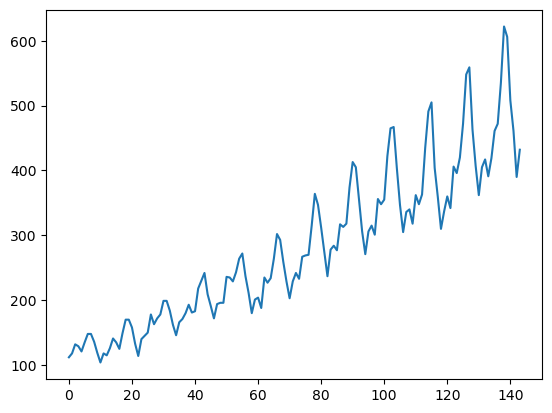

In [9]:
plt.plot(dataframe)

In [10]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

In [11]:
dataset

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [30

In [12]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [13]:
dataset[0:2,:]

array([[0.01544401],
       [0.02702703]], dtype=float32)

In [14]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [15]:
# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [16]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [17]:
print(f"Shape of training set:{trainX.shape}")
print("Shape of test set: {}".format(testX.shape))

Shape of training set:(84, 10)
Shape of test set: (38, 10)


In [18]:
######################################################
# Reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
#print('Single LSTM with hidden Dense...')
#model = Sequential()
#model.add(LSTM(64, input_shape=(None, seq_size)))
#model.add(Dense(32))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
##monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
##                        verbose=1, mode='auto', restore_best_weights=True)
#model.summary()
#print('Train...')
#########################################

#Stacked LSTM with 1 hidden dense layer
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
#model = Sequential()
#model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
#model.add(LSTM(50, activation='relu'))
#model.add(Dense(32))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')
#
#model.summary()
#print('Train...')
###############################################

#Bidirectional LSTM
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#
##For some sequence forecasting problems we may need LSTM to learn
## sequence in both forward and backward directions
#from keras.layers import Bidirectional
#model = Sequential()
#model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')
#model.summary()
#print('Train...')

#########################################################
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')



###############################################

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 64)          19200     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)


# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
3/3 - 4s - loss: 0.0749 - val_loss: 0.3844 - 4s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0566 - val_loss: 0.3120 - 51ms/epoch - 17ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0417 - val_loss: 0.2478 - 56ms/epoch - 19ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0296 - val_loss: 0.1904 - 46ms/epoch - 15ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0202 - val_loss: 0.1398 - 47ms/epoch - 16ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0143 - val_loss: 0.0963 - 54ms/epoch - 18ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0112 - val_loss: 0.0638 - 52ms/epoch - 17ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0107 - val_loss: 0.0448 - 56ms/epoch - 19ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0116 - val_loss: 0.0365 - 50ms/epoch - 17ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0121 - val_loss: 0.0350 - 49ms/epoch - 16ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0115 - val_loss: 0.0373 - 54ms/epoch - 18ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0104 - val_loss: 0.0420 - 49ms/epoch - 16ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0095 - va

In [20]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [21]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.28 RMSE
Test Score: 49.65 RMSE


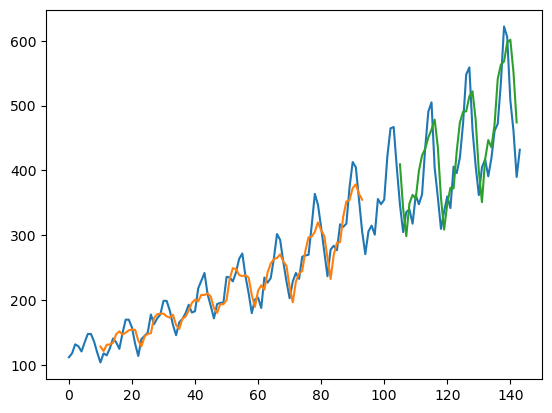

In [22]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()